<a href="https://colab.research.google.com/github/Gabriele90/Biohacker90/blob/main/Predicting_environmental_carcinogens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***PREDICTING ENVIRONMENTAL CARCINOGENS USING ML ALGORITHMS***

The p53 gene encodes a protein of the same name and is known as a tumor-suppressor protein. The p53 protein is expressed in cells when they undergo DNA damage — which can transform a normal cell into a cancerous one. To counteract the effects, p53 can cause growth arrest, repair DNA, or begin the process of cell death. Therefore, when DNA damage occurs, there is a significant increase in p53 expression. This increase in protein expression is a good indicator of irregular cell health. The Tox21 data was generated by testing cell lines which produce a florescent reporter gene product under the control of p53 cellular machinery. By measuring levels of the reporter gene product against various compounds, researchers were able to determine whether a compound was an agonist (activator) of the p53 pathway or not.

**Preparing the data**

The Tox21 data is already labeled with active (1) and inactive (0) states so there really isn’t much to do in this step other than load, format column names, and generate mol files for each molecule.

In [1]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
! conda install -c rdkit rdkit -y
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-11-30 09:33:12--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   148MB/s    in 0.5s    

2020-11-30 09:33:13 (148 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

**Preparing the data**

The Tox21 data is already labeled with active (1) and inactive (0) states so there really isn’t much to do in this step other than load, format column names, and generate mol files (these files are generally classified as data files that contain molecular data information, atom, bonds, coordinates and connectivity information) for each molecule.

In [2]:
import numpy as np
import pandas as pd
import os
from collections import Counter
!conda install -c rdkit 
# Required RDKit modules
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions

# modeling
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from imblearn.over_sampling import ADASYN
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns


CondaValueError: too few arguments, must supply command line package specs or --file



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)



**Loading and formatting**

To follow along, edit the path to where the data is on your machine. We load an sdf file which is a structure-data file and contains associated data for compounds. We actually don't need these details as they wont add to classifying p53 agonists, hence we drop them. For example the "formula column" gives us no usable information at all since its the empirical formula and doesn't contain the valuable structural information a SMILES string provides. We do need mol representations of the molecules so we generate those.

In [3]:
sdfFile = "sr-p53.sdf.txt"
p53 = PandasTools.LoadSDF(sdfFile,smilesName='SMILES',molColName='Molecule', includeFingerprints=True)
p53 = p53.drop(['DSSTox_CID', 'FW', "Formula", 'Molecule'], axis=1)
p53.head()

RDKit ERROR: [09:34:37] Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [09:34:37] ERROR: Could not sanitize molecule ending on line 104652
RDKit WARNING: [09:34:43] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [09:34:37] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [09:34:45] Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [09:34:45] ERROR: Could not sanitize molecule ending on line 400224
RDKit ERROR: [09:34:45] ERROR: Explicit valence for atom # 2 Si, 8, is greater than permitted
RDKit ERROR: [09:34:47] Explicit valence for atom # 3 Mg, 4, is greater than permitted
RDKit ERROR: [09:34:47] ERROR: Could not sanitize molecule ending on line 446411


,Active,ID,SMILES
0,1,NCGC00166288-01,CCN1C(=CC=Cc2sc3ccccc3[n+]2CC)Sc2ccccc21.[I-]
1,1,NCGC00185752-01,COC(=O)C[C@](O)(CCCC(C)(C)O)C(=O)O[C@@H]1C(OC)...
2,0,NCGC00094121-01,Cc1cccc(C)c1OCC(C)N.Cl
3,1,NCGC00241107-01,CO.COc1cc(Nc2c(C#N)cnc3cc(OCCCN4CCN(C)CC4)c(OC...
4,0,NCGC00094586-01,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](N)c3ccc(O)cc3)...


**mol Generation and unique records**

We should also ensure that there aren't any duplicates in the data. This data set in particular has a total number of 8629 records and only 6826 unique records, meaning that ~20% of the data is duplicated and needs to be dropped.

In [4]:
p53["mol"] = [Chem.MolFromSmiles(x) for x in p53["SMILES"]]
#count the nummber of unique rows in the SMILES column
p53['SMILES'].nunique()

#Compare that with total rows
p53['SMILES'].count()

#we can drop the duplicated ones
p53 = p53.drop_duplicates(['SMILES'])

RDKit WARNING: [09:34:48] WARNING: not removing hydrogen atom without neighbors


**Fingerprint generation**

Here is an example of fingerprint generation using the Morgan algorithm. A fingerprint is generated for each compound in the "mol" column with a radius of 2 and a bit length of 2048. A list with the same parameters is also generated for each mol. A for loop then iterates through the loop to create a numpy array and append a new list denoted by "np" in the name. These lists will become our x variables when running the classifiers.

In [5]:
#create a column for the morgan fingerprints
p53["morg_fp"] = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in p53['mol']]

# generate morgan fingeprints with radius 2 contained in a list
morg_fp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in p53['mol']]

# convert the RDKit explicit vectors into numpy arrays
morg_fp_np = []
for fp in morg_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  morg_fp_np.append(arr)

In [6]:
#create a column for the RDKit fingerprints
p53["rd_fp"] = [Chem.RDKFingerprint(m) for m in p53["mol"]]

#The fingerprinting algorithm used is similar to that used in the Daylight fingerprinter
rd_fp = [Chem.RDKFingerprint(m) for m in p53["mol"]]

rd_fp_np = []
for fp in rd_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  rd_fp_np.append(arr)

In [7]:
#create a column for the Atom-pair fingerprints
p53["AP_fp"] = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in p53["mol"]]

#get atom-par fingerprints
AP_fp = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in p53["mol"]]

#convert the RDKit explicit vectors into numpy arrays
AP_fp_np = []
for fp in AP_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  AP_fp_np.append(arr)

In [8]:
#create a column for the topological torsion fingerprints
p53["torsion_fp"] = torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in p53["mol"]]

#get topological torsion fingerprints
torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in p53["mol"]]

#convert the RDKit explicit vectors into numpy arrays
torsion_fp_np = []
for fp in torsion_fp:
  arr = np.zeros((1,))
  DataStructs.ConvertToNumpyArray(fp, arr)
  torsion_fp_np.append(arr)

**Setting the x and y variables**

In [9]:
#morgan fingerprints
x_morg = morg_fp_np

#daylight-like fingerprints
x_rd = rd_fp_np

#atom-pair fingerprints
x_AP = AP_fp_np

#topological torsion fingerprints
x_torsion = torsion_fp_np

#classification labels
y = p53.Active.values

**Sampling: Are the classes balanced?**

When the classification labels (in our case: active = 1; inactive = 0) are skewed in proportion, bias is introduced into the model. For example, if the data set contains 95% active labels then the model will likely classify an inactive molecule as an active one, simply put, the accuracy will reflect the class class distribution. Determining if class imbalance is straight forward — count the distribution of labels. Once we determine how prevalent the minority class is in our data set, we can move forward with balancing it out.

Text(0.5, 0.98, '0: 6406, 1: 420')

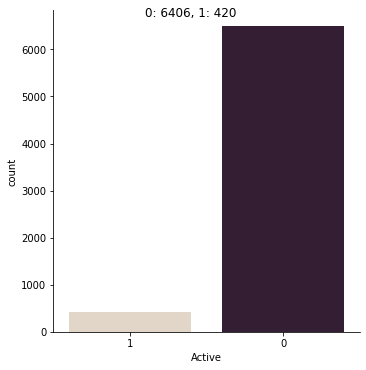

In [10]:
#store the activity labels of all compounds
y = p53.Active.values

#return the count for each unique value (0 and 1)
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

#plot the label counts 
count1 = sns.catplot(x="Active", kind="count", palette="ch:.25", data=p53)

#I added the count of class labels as the title here
count1.fig.suptitle('0: 6406, 1: 420')

The count plot above shows us that there is a disproportionate distribution of classes in our data, a ratio of 15:1 (inactive to active) meaning approximately ~93.84% of our classes being inactive.

**Methods of class balancing**

There are two ways to balance the data: over-sampling and under-sampling. Over sampling brings balance by generating synthetic data points using using one of many algorithms. The one we will use today is a variation of the SMOTE (Synthetic Minority Over-Sampling Technique) algorithm. SMOTE works by searching for the k-nearest neighbors for a given point of data and then generates data points along the line between neighbors. Since these points fall on a line between the real data points, there is some correlation, which is why we will use the ADASYN algorithm (Adaptive Synthetic). ADASYN works essentially the same way SMOTE does, however, it adds small randomly generated values to the points to increase variance and simulate more realistic data.

We opted not to use under-sampling since it balances the classes by removing data points from the majority class and therefore there is a loss of data, possibly affecting the classifier's ability to discriminate.

In [11]:
x_morg_rsmp, y_morg_rsmp = ADASYN().fit_resample(x_morg, y)
morg_sample_count = sorted(Counter(y_morg_rsmp).items())

x_rd_rsmp, y_rd_rsmp = ADASYN().fit_resample(x_rd, y)
rd_sample_count = sorted(Counter(y_rd_rsmp).items())

x_AP_rsmp, y_AP_rsmp = ADASYN().fit_resample(x_AP, y)
AP_sample_count = sorted(Counter(y_rd_rsmp).items())

x_torsion_rsmp, y_torsion_rsmp = ADASYN().fit_resample(x_torsion, y)
torsion_sample_count = sorted(Counter(y_rd_rsmp).items())

print("Morgan distribution:", morg_sample_count, 
      "Daylight-like distribution:", rd_sample_count, 
      "Atom-pair distribution:", AP_sample_count, 
      "Torsion distribution:", torsion_sample_count)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Morgan distribution: [('0', 6504), ('1', 6446)] Daylight-like distribution: [('0', 6504), ('1', 6535)] Atom-pair distribution: [('0', 6504), ('1', 6535)] Torsion distribution: [('0', 6504), ('1', 6535)]


**Plotting one of the re-sampled distributions to visually represent class balance:**

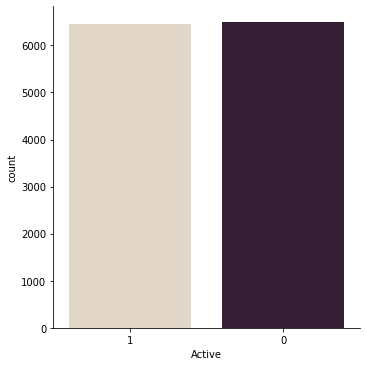

In [12]:
y_morg_rsmp_df = pd.DataFrame(y_morg_rsmp, columns=['Active'])
sns.catplot(x="Active", kind="count", palette="ch:.25", data=y_morg_rsmp_df);

**Logistic Regression**

The logistic regression algorithm classifies a categorical response (outcome) variable between 1 and 0 based on its relationship with predictive features. In contrast, linear regression outputs response variables that are continuous and can be any real number. Most importantly, linear regression does not output probabilities and instead fits the best hyperplane. Therefore logistic regression is the natural choice for a binary classification problem such as ours.

**Creating training, testing, and validation test sets**

In order to train, test, and then test again we need to create three separate data partitions. The training data will be used to train our model - essentially the model will use this data to learn which fingerprints (the 2048 bit patterns) likely belong to p53 agonists. The test set will be used to evaluate the accuracy of our model, and lastly a validation set will be used as unbiased data set to test the predictive ability of our model. Our data will be split into 85/15 train/test sets and then the training data will be further split into an 85/15 train/validation set.

In [13]:
#Partitioning the data into an 85/15 train/test split
x_morg_train, x_morg_test, y_morg_train, y_morg_test = train_test_split(x_morg_rsmp, y_morg_rsmp, test_size=0.15, random_state=1)
#The training data is further split into an 80/15 train/validtion split 
x_morg_train, x_morg_val, y_morg_train, y_morg_val = train_test_split(x_morg_train, y_morg_train, test_size=0.15, random_state=1)

x_rd_train, x_rd_test, y_rd_train, y_rd_test = train_test_split(x_rd_rsmp, y_rd_rsmp, test_size=0.15, random_state=1)
x_rd_train, x_rd_val, y_rd_train, y_rd_val = train_test_split(x_rd_train, y_rd_train, test_size=0.15, random_state=1)

x_AP_train, x_AP_test, y_AP_train, y_AP_test = train_test_split(x_AP_rsmp, y_AP_rsmp, test_size=0.15, random_state=1)
x_AP_train, x_AP_val, y_AP_train, y_AP_val = train_test_split(x_AP_train, y_AP_train, test_size=0.15, random_state=1)

x_torsion_train, x_torsion_test, y_torsion_train, y_torsion_test = train_test_split(x_torsion_rsmp, y_torsion_rsmp, test_size=0.15, random_state=1)
x_torsion_train, x_torsion_val, y_torsion_train, y_torsion_val = train_test_split(x_torsion_train, y_torsion_train, test_size=0.15, random_state=1)

**Cross validation and model fitting**

Cross validation is a statistical technique to reduce the risk of over-fitting the data. Over-fitting occurs when the classifier memorizes the data and fits noise and error instead of the underlying relationship between variables. This can occur if the model is overly complex and if there is limited data to train on. Our model doesn't seem to suffer from these two limitations but its good practice to perform cross validation anyway.

The following lines of code show how to perform logistic regression, obtain cross validations scores for each fold (just one iteration on the training data to estimate scores using the chosen classifier). We then model logistic regression over 1000 iterations while performing k-fold (10) cross validation.

In [14]:
#set our linear regression function
lr = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
#fit the data 
#perform 10 fold crossvalidation to estimate accuracy of model
accuracy_morg = cross_val_score(lr, x_morg_train, y_morg_train, scoring='accuracy', cv = 10)

#get the mean of each fold 
print("Accuracy of Model with Cross Validation is:",accuracy_morg.mean() * 100, "(+/- %0.2f)" % accuracy_morg.std())

#Create our model using 10 fold cross valiation, lbfgs, and 1000 iterations - and fit the data to out training set
lr_morg_ = LogisticRegressionCV(cv=10, solver = 'lbfgs', max_iter = 1000).fit(x_morg_train, y_morg_train)

Accuracy of Model with Cross Validation is: 95.95915032679738 (+/- 0.01)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


For the rest of the fingerprints we can simply write a function to model the data:

In [15]:
# A function to train the logistic regression classifier on given x and y training sets
def lrCV_model(x_train, y_train):
    lr = LogisticRegression(solver = 'lbfgs', max_iter = 650)
    model_accuracy = cross_val_score(lr, x_train, y_train, scoring='accuracy', cv = 5)
    accuracy_printout = "Accuracy of Model with Cross Validation is:",model_accuracy.mean() * 100, "(+/- %0.2f)" % model_accuracy.std()
    lr_fit = LogisticRegressionCV(cv=5, solver = 'lbfgs', max_iter = 650, multi_class = "ovr", n_jobs = -1).fit(x_train, y_train)
    
    return lr_fit

In [17]:
#train logistic regression models for all fingerprints
lr_morg = lrCV_model(x_morg_train, y_morg_train)
lr_rd = lrCV_model(x_rd_train, y_rd_train)
lr_AP = lrCV_model(x_AP_train, y_AP_train)
lr_torsion = lrCV_model(x_torsion_train, y_torsion_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


**Model Metrics and prediction**

Test set predictions and confusion matrix
A confusion matrix is a table which describes the performance of the trained model on test data. There are four quadrants comprising the matrix:

true positives (TP): These are compounds that were predicted positive (active p53 agonist) and actually are positive.

true negatives (TN): These compounds were predicted to be inactive and actually are inactive.

false positives (FP): Cases where the compounds are predicted to be active but are actually inactive (Type I error).

false negatives (FN): Cases where the compounds are predicted to be inactive but are actually active (Type II error)

We can plot the confusion matrix for both test and validation set predictions along with accuracy - which is determined through (TP +TN)/Total cases. The confusion matrix on the left is that of the test set predictions and the right is for the validation set.

In [18]:
#predicting using the test set and creating a confusion matrix
predictions_morg_test = lr_morg.predict(x_morg_test)

#confustion matrix for test set predictions
cm_morg_test = metrics.confusion_matrix(y_morg_test, predictions_morg_test)

print(cm_morg_test)

[[900  73]
 [  1 969]]


**Validation set predictions and confusion matrix**

In [19]:
#predicting using the validation set and creating a confusion matrix
predictions_morg_val = lr_morg.predict(x_morg_val)

#confustion matrix for validation set predictions
cm_morg_val = metrics.confusion_matrix(y_morg_val, predictions_morg_val)

print(cm_morg_val)

[[791  67]
 [  0 794]]


**Model accuracy on test set**

In [20]:
score_morg_train = lr_morg.score(x_morg_train, y_morg_train)
print('Accuracy of logistic regression classifier on train set:', score_morg_train)

Accuracy of logistic regression classifier on train set: 0.9948690539818279


**Model accuracy on test set**

In [21]:
score_morg_test = lr_morg.score(x_morg_test, y_morg_test)
print('Accuracy of logistic regression classifier on test set:', score_morg_test)

Accuracy of logistic regression classifier on test set: 0.961914565105507


**Model accuracy on validation set**

In [22]:
score_morg_val = lr_morg.score(x_morg_val, y_morg_val)
print('Accuracy of logistic regression classifier on test set:', score_morg_val)

Accuracy of logistic regression classifier on test set: 0.9594430992736077


**Classification report**

In [23]:
print(classification_report(y_morg_val, predictions_morg_val))

              precision    recall  f1-score   support

           0       1.00      0.92      0.96       858
           1       0.92      1.00      0.96       794

    accuracy                           0.96      1652
   macro avg       0.96      0.96      0.96      1652
weighted avg       0.96      0.96      0.96      1652



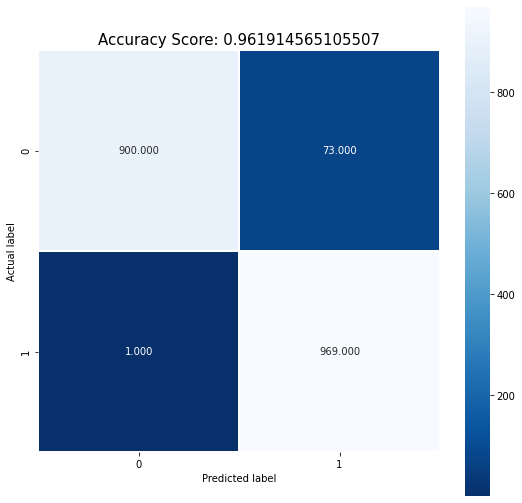

In [24]:

plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_test, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_test)
plt.title(all_sample_title, size = 15);

**Validation set confusion matrix plotted**

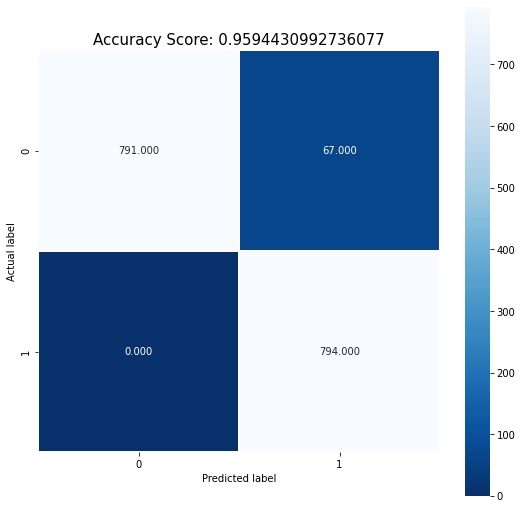

In [25]:
plt.figure(figsize=(9,9))
sns.heatmap(cm_morg_val, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_morg_val)
plt.title(all_sample_title, size = 15);

**Daylight-like fingerprint - logistic regression**

In [26]:
#predicting using the test set and creating a confusion matrix
predictions_rd_test = lr_rd.predict(x_rd_test)

#confustion matrix for test set predictions
cm_rd_test = metrics.confusion_matrix(y_rd_test, predictions_rd_test)

#predicting using the validation set and creating a confusion matrix
predictions_rd_val = lr_rd.predict(x_rd_val)

#confustion matrix for test validation predictions
cm_rd_val = metrics.confusion_matrix(y_rd_val, predictions_rd_val)

print(cm_rd_val)

score_rd_train = lr_rd.score(x_rd_train, y_rd_train)
print('Accuracy of logistic regression classifier on train set:', score_rd_train)

score_rd_test = lr_rd.score(x_rd_test, y_rd_test)
print('Accuracy of logistic regression classifier on test set:', score_rd_test)

score_rd_val = lr_rd.score(x_rd_val, y_rd_val)
print('Accuracy of logistic regression classifier on validation set:', score_rd_val)

print(classification_report(y_rd_val, predictions_rd_val))

[[754  61]
 [  0 848]]
Accuracy of logistic regression classifier on train set: 0.9964968152866241
Accuracy of logistic regression classifier on test set: 0.962678936605317
Accuracy of logistic regression classifier on validation set: 0.963319302465424
              precision    recall  f1-score   support

           0       1.00      0.93      0.96       815
           1       0.93      1.00      0.97       848

    accuracy                           0.96      1663
   macro avg       0.97      0.96      0.96      1663
weighted avg       0.97      0.96      0.96      1663



**Atom-pair fingerprint - logistic regression**

In [27]:
#predicting using the test set and creating a confusion matrix
predictions_AP_test = lr_AP.predict(x_AP_test)

#confustion matrix for test set predictions
cm_AP_test = metrics.confusion_matrix(y_AP_test, predictions_AP_test)

print(cm_AP_test)

#predicting using the validation set and creating a confusion matrix
predictions_AP_val = lr_AP.predict(x_AP_val)

#confustion matrix for test validation predictions
cm_AP_val = metrics.confusion_matrix(y_AP_val, predictions_AP_val)

print(cm_AP_val)

score_AP_train = lr_AP.score(x_AP_train, y_AP_train)
print('Accuracy of logistic regression classifier on train set:', score_AP_train)

score_AP_test = lr_AP.score(x_AP_test, y_AP_test)
print('Accuracy of logistic regression classifier on test set:', score_AP_test)

score_AP_val = lr_AP.score(x_AP_val, y_AP_val)
print('Accuracy of logistic regression classifier on validation set:', score_AP_val)

print(classification_report(y_AP_val, predictions_AP_val))

[[882 107]
 [  0 961]]
[[730  86]
 [  0 842]]
Accuracy of logistic regression classifier on train set: 0.9984027260142689
Accuracy of logistic regression classifier on test set: 0.9451282051282052
Accuracy of logistic regression classifier on validation set: 0.9481302774427021
              precision    recall  f1-score   support

           0       1.00      0.89      0.94       816
           1       0.91      1.00      0.95       842

    accuracy                           0.95      1658
   macro avg       0.95      0.95      0.95      1658
weighted avg       0.95      0.95      0.95      1658



**Topological torsion fingerprint - logistic regression**

In [28]:

#predicting using the test set and creating a confusion matrix
predictions_torsion_test = lr_torsion.predict(x_torsion_test)

#confustion matrix for test set predictions
cm_torsion_test = metrics.confusion_matrix(y_torsion_test, predictions_torsion_test)

print(cm_torsion_test)

#predicting using the validation set and creating a confusion matrix
predictions_torsion_val = lr_torsion.predict(x_torsion_val)

#confustion matrix for test validation predictions
cm_torsion_val = metrics.confusion_matrix(y_torsion_val, predictions_torsion_val)

print(cm_torsion_val)

score_torsion_train = lr_torsion.score(x_torsion_train, y_torsion_train)
print('Accuracy of logistic regression classifier on train set:', score_torsion_train)

score_torsion_test = lr_torsion.score(x_torsion_test, y_torsion_test)
print('Accuracy of logistic regression classifier on test set:', score_torsion_test)

score_torsion_val = lr_torsion.score(x_torsion_val, y_torsion_val)
print('Accuracy of logistic regression classifier on validation set:', score_torsion_val)

print(classification_report(y_torsion_val, predictions_torsion_val))

[[877 118]
 [  9 938]]
[[752  84]
 [  6 809]]
Accuracy of logistic regression classifier on train set: 0.9949748743718593
Accuracy of logistic regression classifier on test set: 0.9346035015447992
Accuracy of logistic regression classifier on validation set: 0.9454875832828589
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       836
           1       0.91      0.99      0.95       815

    accuracy                           0.95      1651
   macro avg       0.95      0.95      0.95      1651
weighted avg       0.95      0.95      0.95      1651



**Grid searching and model fitting**

Perform a grid search with cross validation to determine the optimal number of neighbors for our data. We will test 9 candidate numbers (3, 5, 7, 9, 11, 13, 15, 17, 19) and perform a 5 fold cross validation. This however may take a while since 9 neighbors x 5-fold validation for each amounts to 45 fits. 

In [30]:
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19], 'weights': ['distance'], 'metric': ['euclidean']}
knn_cv = GridSearchCV(knn, grid_params, cv=2, verbose = 1, n_jobs = -1)

knn_morg = knn_cv.fit(x_morg_train, y_morg_train)

knn_cv.best_params_
knn_cv.best_score_

Fitting 2 folds for each of 9 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 19.9min finished


0.8660620368219654

To test out a range of k neighbors numbers we can fit different fingerprint data with varying k values. Using the Atom-pair training data I tested k = 3, 5, 7, 9 which resulted in following accuracy scores in order:

0.846
0.846
0.815
0.785

It seems that 3 and 5 had the same scores, however 3 was likely chosen due to less computation time. Now to finish off, train the models with k=3 and compute their accuracy scores on first the test data and then validation data To test out a range of k neighbors numbers we can fit different fingerprint data with varying k values. Using the Atom-pair training data I tested k = 3, 5, 7, 9 which resulted in following accuracy scores in order:

In [31]:
knn_3n = KNeighborsClassifier(n_neighbors=3)
knn_AP = knn_3n.fit(x_AP_train, y_AP_train)

knn_5n = KNeighborsClassifier(n_neighbors=5)
knn_AP5 = knn_5n.fit(x_AP_train, y_AP_train)

knn_7n = KNeighborsClassifier(n_neighbors=7)
knn_AP7 = knn_7n.fit(x_AP_train, y_AP_train)

knn_9n = KNeighborsClassifier(n_neighbors=9)
knn_AP9 = knn_9n.fit(x_AP_train, y_AP_train)

knn_AP_3n = knn_AP.score(x_AP_test, y_AP_test)
print(knn_AP_3n)
knn_AP_5n = knn_AP5.score(x_AP_test, y_AP_test)
print(knn_AP_5n)
knn_AP_7n = knn_AP7.score(x_AP_test, y_AP_test)
print(knn_AP_7n)
knn_AP_9n = knn_AP9.score(x_AP_test, y_AP_test)
print(knn_AP_9n)

0.8717948717948718
0.84
0.8158974358974359
0.7958974358974359


**Training the models and writing a function for scoring**

In [32]:
knn3 = KNeighborsClassifier(n_neighbors=3)
knn_morg = knn3.fit(x_morg_train, y_morg_train)
knn_rd = knn3.fit(x_rd_train, y_rd_train)
knn_AP = knn3.fit(x_AP_train, y_AP_train)
knn_torsion = knn3.fit(x_torsion_train, y_torsion_train)

def mod_acc_knn(x_train, y_train, x_test, y_test):
    knn3 = KNeighborsClassifier(n_neighbors=3)
    knn_fp = knn3.fit(x_train, y_train)
    score_fp_test_knn = knn_fp.score(x_test, y_test)
    return score_fp_test_knn

**knn training data accuracy**

In [33]:
knn_morg_acc_train = mod_acc_knn(x_morg_train, y_morg_train, x_morg_train, y_morg_train)
print(knn_morg_acc_train)
knn_rd_acc_train = mod_acc_knn(x_rd_train, y_rd_train, x_rd_train, y_rd_train)
print(knn_rd_acc_train)
knn_AP_acc_train = mod_acc_knn(x_AP_train, y_AP_train, x_AP_train, y_AP_train)
print(knn_AP_acc_train)
knn_torsion_acc_train = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_train, y_torsion_train)
print(knn_torsion_acc_train)

0.9553180117584179
0.9544585987261146
0.9360025556383772
0.9309312520047044


**knn test data accuracy**

In [34]:
knn_morg_acc_test = mod_acc_knn(x_morg_train, y_morg_train, x_morg_test, y_morg_test)
print(knn_morg_acc_test)
knn_rd_acc_test = mod_acc_knn(x_rd_train, y_rd_train, x_rd_test, y_rd_test)
print(knn_rd_acc_test)
knn_AP_acc_test = mod_acc_knn(x_AP_train, y_AP_train, x_AP_test, y_AP_test)
print(knn_AP_acc_test)
knn_torsion_acc_test = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_test, y_torsion_test)
print(knn_torsion_acc_test)

0.9181677817807514
0.9054192229038854
0.8717948717948718
0.8697219361483007


**knn validation data accuracy**

In [35]:
knn_morg_acc_val = mod_acc_knn(x_morg_train, y_morg_train, x_morg_val, y_morg_val)
print(knn_morg_acc_val)
knn_rd_acc_val = mod_acc_knn(x_rd_train, y_rd_train, x_rd_val, y_rd_val)
print(knn_rd_acc_val)
knn_AP_acc_val = mod_acc_knn(x_AP_train, y_AP_train, x_AP_val, y_AP_val)
print(knn_AP_acc_val)
knn_torsion_acc_val = mod_acc_knn(x_torsion_train, y_torsion_train, x_torsion_val, y_torsion_val)
print(knn_torsion_acc_val)

0.8964891041162227
0.915213469633193
0.8667068757539204
0.8673531193216233


**Gradient boosting**

So far we have fit a single model to the training data for each classier. Gradient boosting combines many individual models to create a single accurate one - this is known as an ensemble. Boosting is the method used to create an ensemble. It works by fitting the data with an initial model, then a subsequent model is built which works on accurately predicting the labels that the initial model classified incorrectly. Essentially, every subsequent model works to minimize the prediction error of the previous model which leads to an overall decrease in prediction error. Therefore predictions made by the final model are the result of the weighted sum of predictions calculated by all previous models

**Grid searching and model training, and metrics**

In [36]:
#set search parameters
params_gb = {
    "loss":["deviance"],
    "learning_rate": [1.0],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,7],
    "max_features":["sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.75, 0.95],
    "n_estimators":[100]
    }

#initialize grid seach
gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=2, n_jobs=-1, verbose = 2)
#train the model while tuning 
gb_morg = gb.fit(x_morg_train, y_morg_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 14.8min finished


Check out the accuracy on the test and validation data

In [37]:
print(gb_morg.score(x_morg_train, y_morg_train))
print(gb_morg.score(x_morg_test, y_morg_test))
print(gb_morg.score(x_morg_val, y_morg_val))

0.9200427578834848
0.9181677817807514
0.9225181598062954


In [39]:
#initialize grid seach
gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=2, n_jobs=-1, verbose = 2)
#train the model while tuning 
gb_rd = gb.fit(x_rd_train, y_rd_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 22.9min finished


In [40]:
print(gb_rd.score(x_rd_train, y_rd_train))
print(gb_rd.score(x_rd_test, y_rd_test))
print(gb_rd.score(x_rd_val, y_rd_val))

0.9835456475583864
0.9616564417177914
0.9561034275405893


In [41]:
#initialize grid seach
gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=2, n_jobs=-1, verbose = 2)
#train the model while tuning 
gb_AP = gb.fit(x_AP_train, y_AP_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 19.0min finished


In [42]:
print(gb_AP.score(x_AP_train, y_AP_train))
print(gb_AP.score(x_AP_test, y_AP_test))
print(gb_AP.score(x_AP_val, y_AP_val))

0.9676285805558513
0.9548717948717949
0.9607961399276237


In [43]:
#initialize grid seach
gb = GridSearchCV(GradientBoostingClassifier(), params_gb, cv=2, n_jobs=-1, verbose = 2)
#train the model while tuning 
gb_torsion = gb.fit(x_torsion_train, y_torsion_train)

Fitting 2 folds for each of 1296 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1009 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 1981 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 15.0min finished


In [44]:
print(gb_torsion.score(x_torsion_train, y_torsion_train))
print(gb_torsion.score(x_torsion_test, y_torsion_test))
print(gb_torsion.score(x_torsion_val, y_torsion_val))

0.8503154068213408
0.849124613800206
0.8479709267110842


**The Area Under Curve (AUC)**

AUC value is another measure to evaluate the performance of a model on a binary classification task and is one of the most widely used metrics for evaluation. Two properties of a given model are needed to calculate the AUC - sensitivity and specificity. Sensitivity is the proportion of correctly classified positive points of data compared to all data points classified as positive. Sensitivity is the proportion of data points that were correctly classified as negative compared to all data points classified as negative.

Sensitivity of a model: True positive / (False Negative + True positive).
Specificity of a model: True negative / (False positive + True negative).
When the true positive rate is plotted against the false positive rate, the AUC of this curve can be calculated and essentially scores the ability of the model to distinguish between the two classes. A higher AUC means that molecules classified as p53 agonists are indeed more likely to be agonists.

In [45]:
def auc_calc(x_val, y_val, model):
    # Probability predictions using validation data
    prob = model.predict_proba(x_val)
    # Correct probability predictions
    prob = prob[:, 1]
    # Calculate area under the curve with validation data labels and correct predicted probabilities
    auc = metrics.roc_auc_score(y_val, prob)
    # Return the AUC score with 6 figures
    return 'AUC: %.6f' % auc

Morgan fingerprint auc values for all three models

In [46]:
morg_lr_auc = auc_calc(x_morg_val, y_morg_val, lr_morg)
print("AUC using logistic regression: ", morg_lr_auc)
morg_knn_auc = auc_calc(x_morg_val, y_morg_val, knn_morg)
print("AUC using k-nearest naighbor: ", morg_knn_auc)
morg_gb_auc = auc_calc(x_morg_val, y_morg_val, gb_morg)
print("AUC using gradient boosting: ", morg_gb_auc)

AUC using logistic regression:  AUC: 0.983149
AUC using k-nearest naighbor:  AUC: 0.520990
AUC using gradient boosting:  AUC: 0.971548


Daylight-like fingerprint auc values for all three models¶

In [47]:
rd_lr_auc = auc_calc(x_rd_val, y_rd_val, lr_rd)
print("AUC using logistic regression: ", rd_lr_auc)
rd_knn_auc = auc_calc(x_rd_val, y_rd_val, knn_rd)
print("AUC using k-nearest neighbor: ", rd_knn_auc)
rd_gb_auc = auc_calc(x_rd_val, y_rd_val, gb_rd)
print("AUC using gradient boosting: ", rd_gb_auc)

AUC using logistic regression:  AUC: 0.981204
AUC using k-nearest neighbor:  AUC: 0.582470
AUC using gradient boosting:  AUC: 0.981838


Atom-pair fingerprint auc values for all three models

In [48]:
AP_lr_auc = auc_calc(x_AP_val, y_AP_val, lr_AP)
print("AUC using logistic regression: ", AP_lr_auc)
AP_knn_auc = auc_calc(x_AP_val, y_AP_val, knn_AP)
print("AUC using k-nearest naighbor: ", AP_knn_auc)
AP_gb_auc = auc_calc(x_AP_val, y_AP_val, gb_AP)
print("AUC using gradient boosting: ", AP_gb_auc)

AUC using logistic regression:  AUC: 0.958626
AUC using k-nearest naighbor:  AUC: 0.594346
AUC using gradient boosting:  AUC: 0.986031


Topologial torsion fingerprint auc values for all three models

In [49]:
torsion_lr_auc = auc_calc(x_torsion_val, y_torsion_val, lr_torsion)
print("AUC using logistic regression: ", torsion_lr_auc)
torsion_knn_auc = auc_calc(x_torsion_val, y_torsion_val, knn_torsion)
print("AUC using k-nearest naighbor: ", torsion_knn_auc)
torsion_gb_auc = auc_calc(x_torsion_val, y_torsion_val, gb_torsion)
print("AUC using gradient boosting: ", torsion_gb_auc)

AUC using logistic regression:  AUC: 0.944487
AUC using k-nearest naighbor:  AUC: 0.930460
AUC using gradient boosting:  AUC: 0.910007


**f1-score**

The f1-score of a model is calculated using recall (calculated like sensitivity) and precision, which is the rate of:

true positive / (false positive + true positive).

A F1 Score finds a balance between a models recall (fewer predicted points turning out to be false negatives) and precision (fewer predicted points turning out to be false positives).

In [50]:
def f1score(x_val, y_val, model):
    #predictions made on validation data
    predictions = model.predict(x_val)
    #generating the classification report
    clrpt = classification_report(y_val, predictions, output_dict = True)
    #accessing the weighted average entery in dictionairy
    d = clrpt["weighted avg"]
    #calling the f1_score
    f1 = d['f1-score']
    return 'f1-score %.6f' % f1

Morgan fingerprint f-scores for all three models using validation data.

In [51]:
morg_lr_f1 = f1score(x_morg_val, y_morg_val, lr_morg)
morg_knn_f1 = f1score(x_morg_val, y_morg_val, knn_morg)
morg_gb_f1 = f1score(x_morg_val, y_morg_val, gb_morg)
print(morg_lr_f1)
print(morg_knn_f1)
print(morg_gb_f1)

f1-score 0.959440
f1-score 0.422707
f1-score 0.922346


Daylight-like fingerprint f-scores for all three models using validation data

In [52]:
rd_lr_f1 = f1score(x_rd_val, y_rd_val, lr_rd)
rd_knn_f1 = f1score(x_rd_val, y_rd_val, knn_rd)
rd_gb_f1 = f1score(x_rd_val, y_rd_val, gb_rd)
print(rd_lr_f1)
print(rd_knn_f1)
print(rd_gb_f1)

f1-score 0.963243
f1-score 0.475698
f1-score 0.956107


Atom-pair fingerprint f-scores for all three models using validation data

In [53]:
AP_lr_f1 = f1score(x_AP_val, y_AP_val, lr_AP)
AP_knn_f1 = f1score(x_AP_val, y_AP_val, knn_AP)
AP_gb_f1 = f1score(x_AP_val, y_AP_val, gb_AP)
print(AP_lr_f1)
print(AP_knn_f1)
print(AP_gb_f1)

f1-score 0.947948
f1-score 0.572624
f1-score 0.960799


Topological torsion fingerprint f-scores for all three models using validation data

In [54]:
torsion_lr_f1 = f1score(x_torsion_val, y_torsion_val, lr_torsion)
torsion_knn_f1 = f1score(x_torsion_val, y_torsion_val, knn_torsion)
torsion_gb_f1 = f1score(x_torsion_val, y_torsion_val, gb_torsion)
print(torsion_lr_f1)
print(torsion_knn_f1)
print(torsion_gb_f1)

f1-score 0.945399
f1-score 0.865609
f1-score 0.847176


**CONCLUSIONS**

***The best classifier is Logistic regression***

When looking at validation accuracy, logistic regression has the consistently highest scores. Next, when evaluating AUC - arguably the most important metric - gradient boosting produced the highest score but logistic regression had the highest average scores. Lastly, the highest individual and average f1-scores belong to logistic regression, suggesting that it produces models with the greatest balance between precision and robustness.

***The best fingerprint is daylight-like fingerprint***

The results show that the Daylight-like fingerprint had the highest AUC score for both logistic regression and knn - the Atom-pair fingerprint scored only marginally higher when using gradient boosting. However when looking at gradient boosting, Atom-pair fingerprints outscored the Daylight-like fingerprints in validation accuracy, AUC, and F1-scores.
